# Project - Airline AI Assistant


In [2]:
#imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [4]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [5]:
system_message = "You are a helpful assistant for an Airline called FlightAI."
system_message += "Give short, curteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [6]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


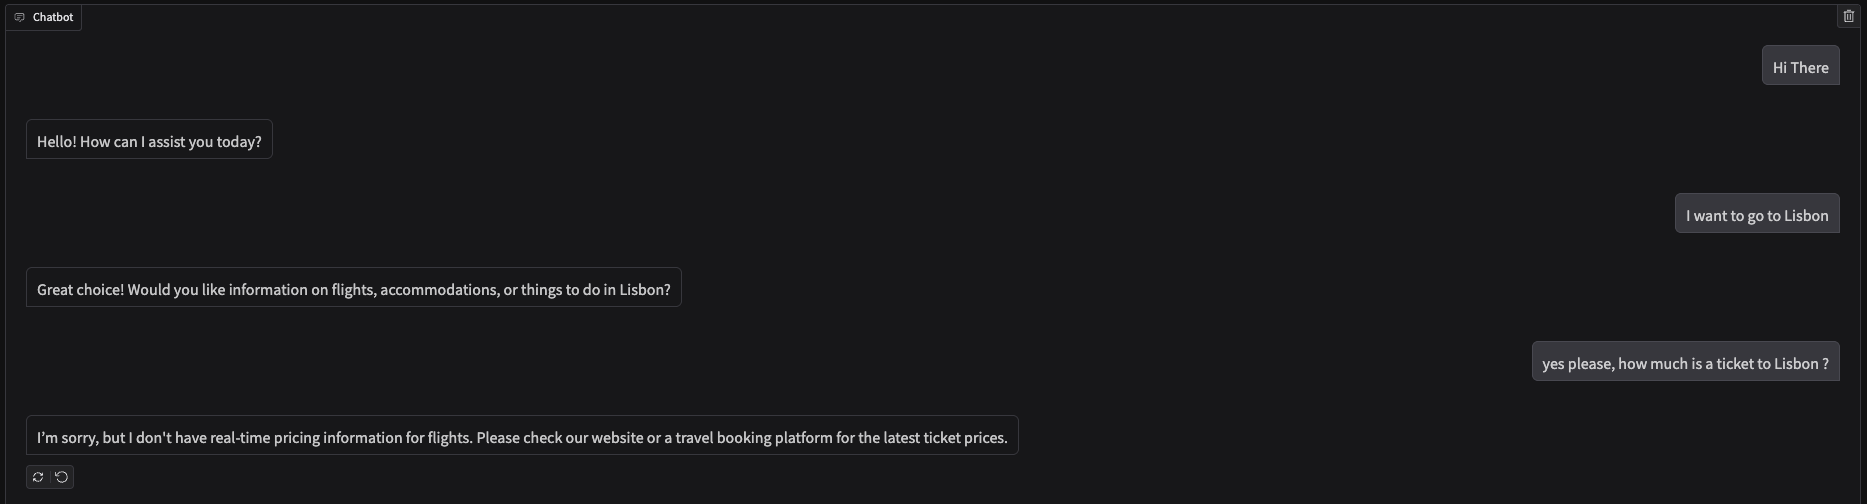

as you can see from the screenshot, it's simple and doesn't hallucinate anything and so far we haven't used any tools yet to provide the information the customer is looking for.

## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

In [7]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499", "lisbon": "$449"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")



In [10]:
get_ticket_price("london")

Tool get_ticket_price called for london


'$799'

In [15]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": (
        "Get the price of a return ticket to the destination city. "
        "Call this whenever you need to know the ticket price, for example when a "
        "customer asks 'How much is a ticket to this city'."
    ),
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False,
    },
}

{'name': 'get_ticket_price', 'description': "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'.", 'parameters': {'type': 'object', 'properties': {'destination_city': {'type': 'string', 'description': 'The city that the customer wants to travel to'}}, 'required': ['destination_city'], 'additionalProperties': False}}


In [18]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [22]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content
    

In [23]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city, "price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [24]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7872
* To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for Lisbon
Tool get_ticket_price called for Berlin
Tool get_ticket_price called for Paris
Tool get_ticket_price called for Porto


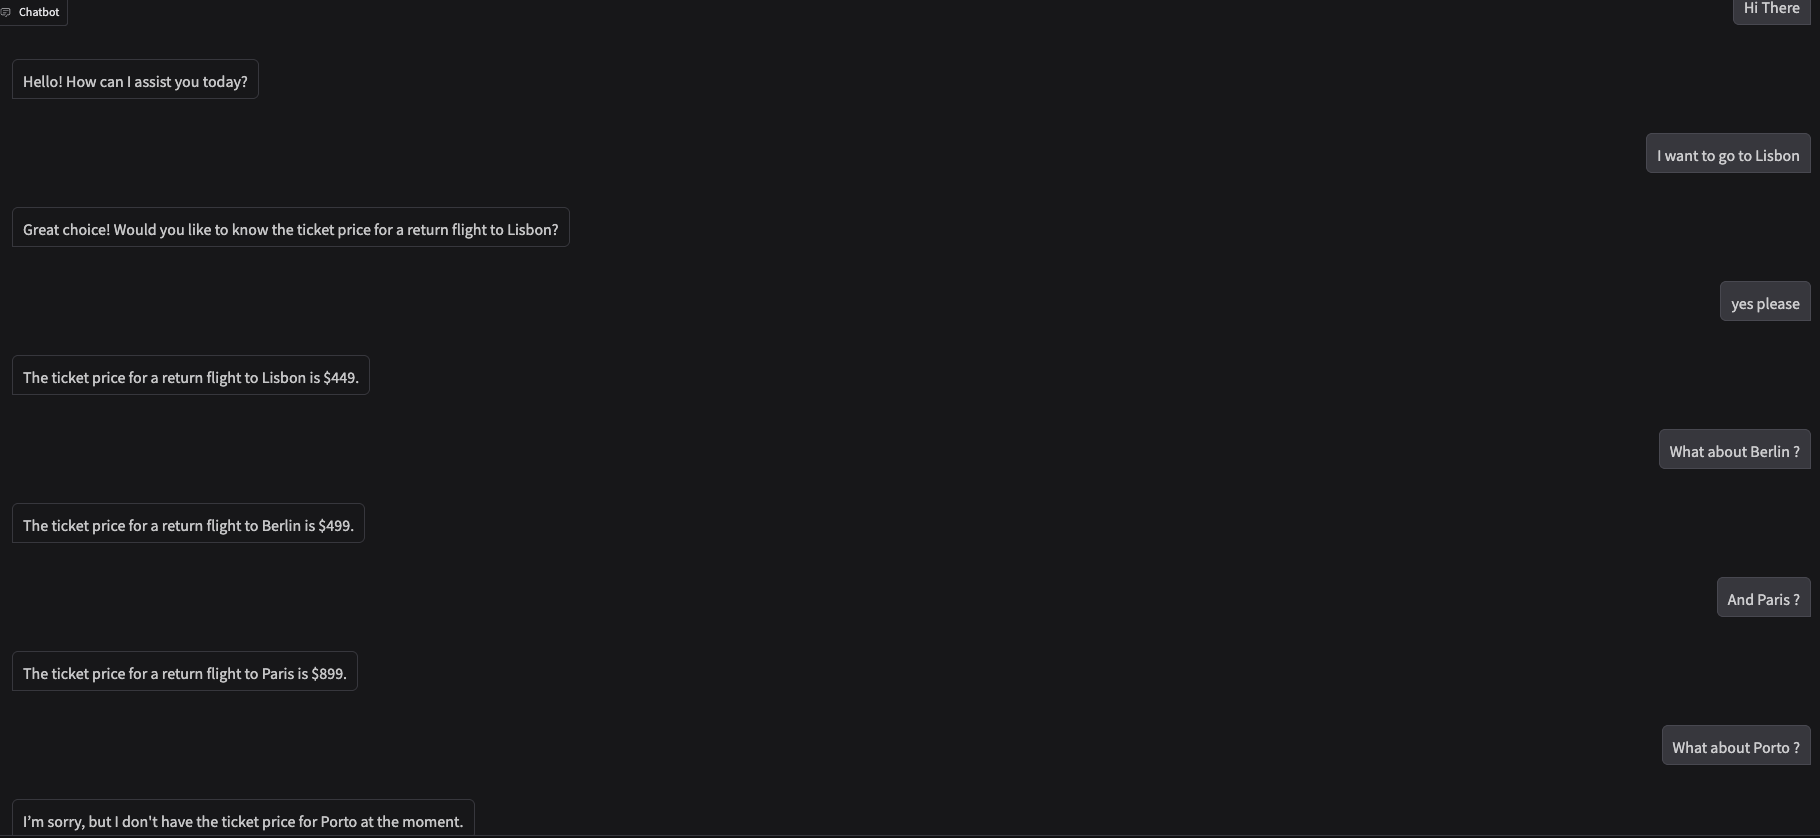

From the above screenshot we can see that our function is being called to fetch the results of Airline Flight ticket.

In the real world scrnario, this could be an exmaple where we would call the real api to fetch the results and provide it to the user, We could also add more for example different dates, availabilty of flights, stops in between, flight payment confirmation details api etc..

As we can see from the above Frontier models like gpt4 from OpenAI, claude from Anthropic have some powerful features that we can use out of the box to build some very useful tools.